In [1]:

import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

2024-01-16 23:04:17.387777: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-16 23:04:17.408844: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-16 23:04:17.408864: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-16 23:04:17.409384: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-16 23:04:17.412791: I tensorflow/core/platform/cpu_feature_guar

In [2]:
x = pd.read_csv("Cary_Weather_Data.csv")
x['DATE'] = pd.to_datetime(x[['YEAR', 'MONTH', 'DAY']])
x = x.drop(columns=['YEAR','MONTH','DAY'])
#x = x.drop(columns=['Humidity','Precipitation','Wind Speed'])
x = x[['DATE', 'Temperature', 'Humidity', 'Precipitation', 'Wind Speed']]
x.set_index('DATE', inplace=True)
x.head()


,Temperature,Humidity,Precipitation,Wind Speed
DATE,,,,
1981-07-01,15.12,10.68,6.65,3.59
1981-07-02,7.53,13.12,10.68,1.64
1981-07-03,7.32,13.79,37.42,2.43
1981-07-04,10.43,14.40,8.41,2.29
1981-07-05,13.13,15.20,4.13,1.58


In [3]:
scaler = StandardScaler()
x_scale = scaler.fit_transform(x)
x_scale = pd.DataFrame(x_scale, columns=x.columns, index=x.index)
x_scale = x_scale.drop(columns=['Humidity', 'Precipitation', 'Wind Speed'])
x_scale.head()

,Temperature
DATE,
1981-07-01,0.926990
1981-07-02,-1.305674
1981-07-03,-1.367448
1981-07-04,-0.452614
1981-07-05,0.341614


In [4]:
def create_dataset(X, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X.iloc[i:(i + time_steps)].values)
        ys.append(X.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

In [5]:
time_steps = 1

X, y = create_dataset(x_scale, time_steps)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=123, shuffle=False)
X_train.shape
X_val.shape


(3106, 1, 1)

In [6]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.InputLayer(input_shape=(time_steps, 1)))

for dilation_rate in (1, 2, 4, 8, 16, 32, 64, 128, 256):
    model.add(tf.keras.layers.Conv1D(filters=32, kernel_size=2, 
                                     strides=1, dilation_rate=dilation_rate, 
                                     padding='causal', activation='relu'))
model.add(tf.keras.layers.Conv1D(filters=1, kernel_size=1))


cp = tf.keras.callbacks.ModelCheckpoint('model', save_best_only=True)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 1, 32)             96        
                                                                 
 conv1d_1 (Conv1D)           (None, 1, 32)             2080      
                                                                 
 conv1d_2 (Conv1D)           (None, 1, 32)             2080      
                                                                 
 conv1d_3 (Conv1D)           (None, 1, 32)             2080      
                                                                 
 conv1d_4 (Conv1D)           (None, 1, 32)             2080      
                                                                 
 conv1d_5 (Conv1D)           (None, 1, 32)             2080      
                                                                 
 conv1d_6 (Conv1D)           (None, 1, 32)             2

2024-01-16 23:04:19.262566: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-16 23:04:19.285620: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-16 23:04:19.288822: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [7]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss='Huber', optimizer=optimizer, metrics=['mae'])


In [8]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='mae', patience=5)

# Learning Rate Scheduler callback
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.1)
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)

cp = tf.keras.callbacks.ModelCheckpoint('best_model.keras', save_best_only=True)

In [9]:

history = model.fit(X_train, y_train, epochs=50, callbacks=[cp, early_stopping])

Epoch 1/50


2024-01-16 23:04:20.408563: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-01-16 23:04:20.451039: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-01-16 23:04:20.511472: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-01-16 23:04:21.248758: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f138418ec80 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-01-16 23:04:21.248772: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3080, Compute Capability 8.6
2024-01-16 23:04:21.252038: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1705464261.291216   19376 device_compiler.

389/389 [==============================] - 6s 9ms/step - loss: 0.3762 - mae: 0.7376
Epoch 2/50
389/389 [==============================] - 3s 9ms/step - loss: 0.3645 - mae: 0.7236
Epoch 3/50
389/389 [==============================] - 3s 8ms/step - loss: 0.3647 - mae: 0.7236
Epoch 4/50
389/389 [==============================] - 3s 8ms/step - loss: 0.3642 - mae: 0.7236
Epoch 5/50
389/389 [==============================] - 3s 7ms/step - loss: 0.3643 - mae: 0.7231
Epoch 6/50
389/389 [==============================] - 3s 8ms/step - loss: 0.3638 - mae: 0.7230
Epoch 7/50
389/389 [==============================] - 3s 7ms/step - loss: 0.3649 - mae: 0.7243
Epoch 8/50
389/389 [==============================] - 2s 6ms/step - loss: 0.3643 - mae: 0.7238
Epoch 9/50
389/389 [==============================] - 4s 10ms/step - loss: 0.3635 - mae: 0.7223
Epoch 10/50
389/389 [==============================] - 3s 8ms/step - loss: 0.3645 - mae: 0.7232
Epoch 11/50
389/389 [==============================] - 3s 8

In [18]:
matplotlib.interactive(True)
%matplotlib qt
plt.plot(history.history['loss'], label='Training Loss')
#plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [15]:
prediction = model.predict(X_val)
prediction_reshape = prediction[:, 0]
x_val_reshz = X_val[:, 0, 0]

 1/98 [..............................] - ETA: 1s

98/98 [==============================] - 0s 892us/step


In [16]:
time_val = x.index[-len(X_val):]

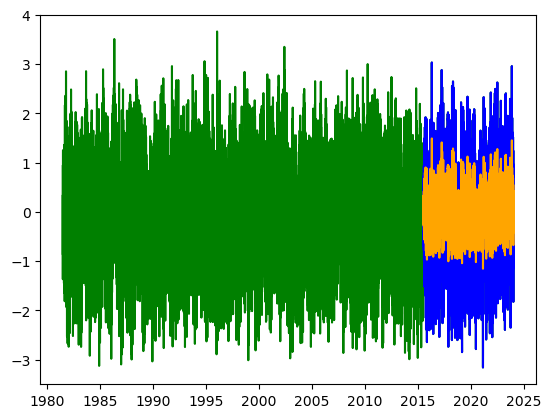

In [17]:

plt.plot(x_scale['Temperature'], color='green')
plt.plot(time_val, x_val_reshz, label='Actual', color='blue')
plt.plot(time_val, prediction_reshape, label='Prediction', color='orange')
plt.show()